In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from google.colab import drive
import random
import tarfile
import os
import skimage.transform as skt

drive.mount('/content/drive')
file_dir = "/content/drive/My Drive/cityscapes.tar.gz"
tarfile.open(file_dir).extractall()

Mounted at /content/drive


In [2]:
input_data = []
label_data = []
folders_dir = 'cityscapes'
for folder_ in os.listdir(folders_dir):
    folder_dir = os.path.join(folders_dir, folder_)
    for data_dir in os.listdir(folder_dir):
        data = plt.imread(os.path.join(folder_dir, data_dir))
        input_data.append(data[:, :256, :])
        label_data.append(data[:, 256:, :])

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Sat Nov 28 09:40:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    13W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:

class DataSet(torch.utils.data.Dataset):
    def __init__(self):
        self.input_data = input_data[:len(input_data) - 20]
        self.label_data = label_data[:len(label_data) - 20]
        self.input_test = input_data[len(input_data) - 20:]
        self.label_test = label_data[len(label_data) - 20:]
        self.SRC_IMAGE_SIZE = 280

    def __len__(self):
        return len(self.input_data)
   
    def __getitem__(self, idx):
        input = skt.resize(self.input_data[idx], (self.SRC_IMAGE_SIZE, self.SRC_IMAGE_SIZE))
        label = skt.resize(self.label_data[idx], (self.SRC_IMAGE_SIZE, self.SRC_IMAGE_SIZE))

        lu_x = np.random.randint(0, self.SRC_IMAGE_SIZE - 256)
        lu_y = np.random.randint(0, self.SRC_IMAGE_SIZE - 256)
        input = input[lu_y:lu_y + 256, lu_x:lu_x + 256, :]
        label = label[lu_y:lu_y + 256, lu_x:lu_x + 256, :]

        input = torch.Tensor(input.transpose((2, 0, 1)))
        label = torch.Tensor(label.transpose((2, 0, 1)))
        input = (input - 0.5) / 0.5
        label = (label - 0.5) / 0.5
        return input, label

    def gettest(self, idx):
        input = torch.Tensor(self.input_test[idx].transpose((2, 0, 1)))
        label = torch.Tensor(self.label_test[idx].transpose((2, 0, 1)))
        input = (input - 127.5) / 127.5
        label = (label - 127.5) / 127.5
        return input, label

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=3,   out_channels=64,  kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels=64,  out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc7 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.enc8 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)
        self.drop1 = nn.Dropout2d(0.5)

        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)
        self.drop2 = nn.Dropout2d(0.5)

        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)
        self.drop3 = nn.Dropout2d(0.5)

        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=512),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 512, out_channels=256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 256, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 128, out_channels=64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(0.2),
        ).to(device)

        self.dec8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2 * 64, out_channels=128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode='reflect', bias=False),
            nn.Tanh()
        ).to(device)



    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        enc5 = self.enc5(enc4)
        enc6 = self.enc6(enc5)
        enc7 = self.enc7(enc6)
        enc8 = self.enc8(enc7)

        dec = self.dec1(enc8)
        dec = self.dec2(torch.cat([self.drop1(dec), enc7], dim=1))
        dec = self.dec3(torch.cat([self.drop2(dec), enc6], dim=1))
        dec = self.dec4(torch.cat([self.drop3(dec), enc5], dim=1))
        dec = self.dec5(torch.cat([dec, enc4], dim=1))
        dec = self.dec6(torch.cat([dec, enc3], dim=1))
        dec = self.dec7(torch.cat([dec, enc2], dim=1))
        dec = self.dec8(torch.cat([dec, enc1], dim=1))

        return dec


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3 + 3,   64,  kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,  128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1,   kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        ).to(device)
    
    def forward(self, X):
        return self.net(X)

In [6]:
dataset = DataSet()
mbsz = 4
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)
D = Discriminator()
G = Generator()
D_solver = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
G_solver = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))

In [7]:
path = "/content/drive/My Drive/" + "D_pix2pix.pt"
D.load_state_dict(torch.load(path, device))
path = "/content/drive/My Drive/" + "G_pix2pix.pt"
G.load_state_dict(torch.load(path, device))

<All keys matched successfully>

In [8]:
lambda_dist = 20
train_L1loss = []
train_D_true = []
train_D_fake = []

In [21]:
G.train()
for epoch in range(10):
    train_L1loss.append(0.0)
    train_D_true.append(0.0)
    train_D_fake.append(0.0)
    for _, (input, label) in enumerate(loader):

        input = input.to(device)
        label = label.to(device)

        D_solver.zero_grad()
        D_true = D(torch.cat([input, label], dim=1))
        D_fake = D(torch.cat([G(label).detach(), label], dim=1))
        ((D_true - 1.0).pow(2) + D_fake.pow(2)).mean().backward()
        D_solver.step()

        G_solver.zero_grad()
        input_fake = G(label)
        G_adv = (D(torch.cat([input_fake, label], dim=1)) - 1.0).pow(2).mean()
        L1_dist = torch.abs(input_fake - input).mean()
        (G_adv + lambda_dist * L1_dist).backward()
        G_solver.step()

        train_L1loss[-1] += L1_dist.item()
        train_D_true[-1] += D_true.mean().item()
        train_D_fake[-1] += D_fake.mean().item()
    train_L1loss[-1] /= len(loader) 
    train_D_true[-1] /= len(loader)
    train_D_fake[-1] /= len(loader)
    print(train_L1loss[-1], train_D_true[-1], train_D_fake[-1])


0.1631688072431405 0.8387981752324353 0.1608045233854957
0.16297556793151008 0.8378816685042542 0.16247259347477275
0.16327096393217494 0.8357064604828283 0.1639866593174058
0.16300756168289504 0.8393990431986706 0.15946018948788437
0.16384941827277044 0.8399792645614366 0.15978225993924922
0.16248898594915384 0.8394536601329872 0.16095025416410735
0.16273640596058525 0.8441027098983906 0.15534736803459784
0.16228491132636474 0.8441886227072873 0.1560877664980553
0.16216561101541044 0.8454988250208896 0.1540412289429853
0.1616446421258281 0.8449784244819698 0.15497494687062935


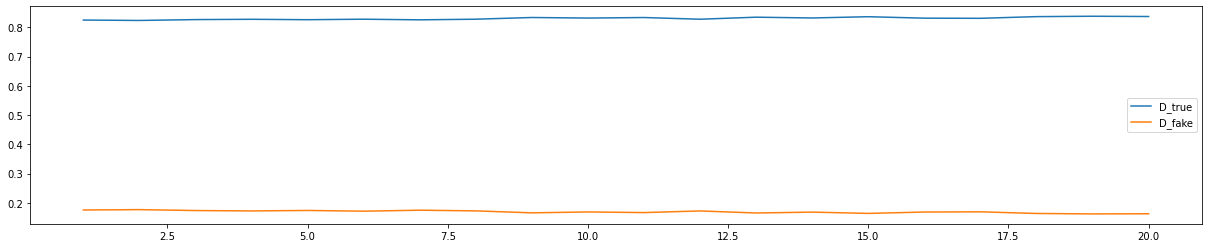

In [14]:
plt.figure(figsize=(21, 4))
plt.plot(np.arange(1, len(train_D_true) + 1), train_D_true, label='D_true')
plt.plot(np.arange(1, len(train_D_fake) + 1), train_D_fake, label='D_fake')
plt.legend()
plt.show()

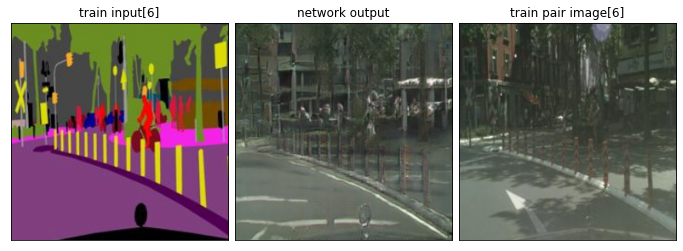

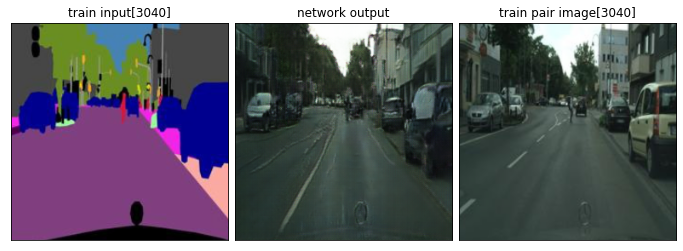

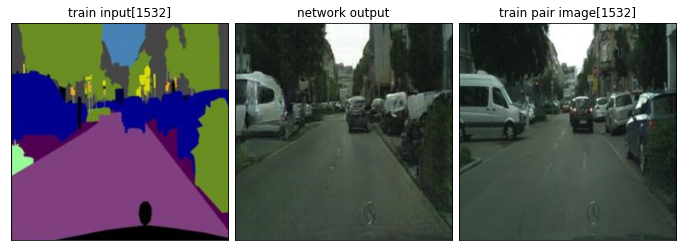

In [39]:
def validation2(idx=None):
    if idx == None:
        idx = np.random.randint(0, len(dataset.input_data) - 1)
    input, label = dataset.__getitem__(idx)
    G.eval()
    input_fake = G(label.unsqueeze(0).to(device))
    G.train()
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    ax.set_title('train input[' + str(idx) + ']')
    ax.imshow((label.permute(1, 2, 0) + 1.0) * 0.5)
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    ax.set_title('network output')
    ax.imshow((input_fake.squeeze(0).cpu().detach().permute(1, 2, 0) + 1.0) * 0.5)
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    ax.set_title('train pair image[' + str(idx) + ']')
    ax.imshow((input.permute(1, 2, 0) + 1.0) * 0.5)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()
    G.train()

    

validation2()
validation2()
validation2()

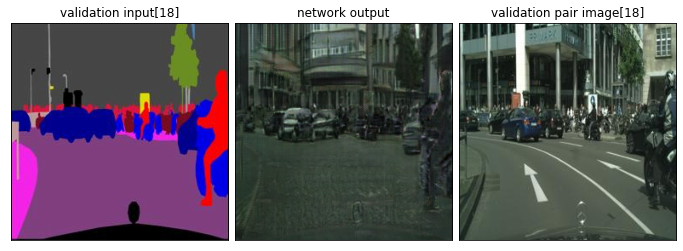

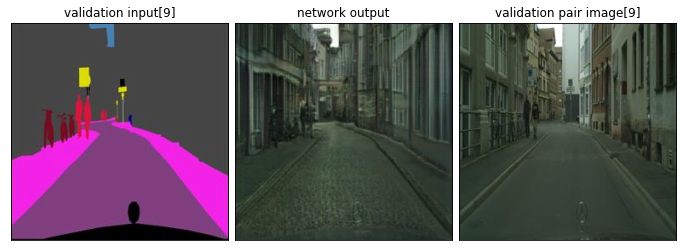

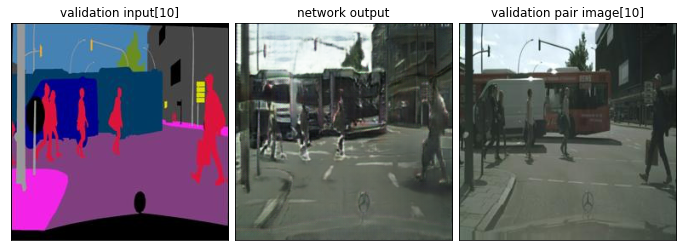

In [42]:
def validation(idx=None):
    if idx == None:
        idx = np.random.randint(0, len(dataset.input_test) - 1)
    input, label = dataset.gettest(idx)
    G.eval()
    input_fake = G(label.unsqueeze(0).to(device))
    G.train()
    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    ax.set_title('validation input[' + str(idx) + ']')
    ax.imshow((label.permute(1, 2, 0) + 1.0) * 0.5)
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    ax.set_title('network output')
    ax.imshow((input_fake.squeeze(0).cpu().detach().permute(1, 2, 0) + 1.0) * 0.5)
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    ax.set_title('validation pair image[' + str(idx) + ']')
    ax.imshow((input.permute(1, 2, 0) + 1.0) * 0.5)
    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()
    G.train()

    

validation()
validation()
validation()

In [43]:
path = "/content/drive/My Drive/"
torch.save(G.state_dict(), path + 'G_pix2pix.pt')
torch.save(D.state_dict(), path + 'D_pix2pix.pt')
print('done!')

# model_save_name = 'dcgan_celeba.pt'
# path = "/content/drive/My Drive/" + model_save_name
# model.load_state_dict(torch.load(path, device))

done!
